# Dual-Branch Hybrid Model for Stock Trend Prediction

This notebook implements a dual-branch deep learning model that integrates textual and financial data with several improvements:

- **Financial Branch:** Replaces the LSTM with a Temporal Convolutional Network (TCN) to capture long-range dependencies.
- **Dynamic Windows:** The financial branch now uses adaptive window sizes based on recent volatility.
- **Improved Sentiment Aggregation:** Instead of simple averaging, news sentiments are aggregated using weighted averaging (with more recent articles receiving higher weight).

The dataset is split based on time (earliest 80% as training and the most recent 20% as testing), and evaluation metrics (MSE, RMSE, MAPE, Spearman correlation) and plots are produced.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, pipeline
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/home/akshat/miniconda3/envs/cvproj/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 1. Load Financial and News Data

Load the stock data from `upload_DJIA_table.csv` and news data from `RedditNews.csv`. For the text branch, we later aggregate the individual news articles per date using weighted aggregation.

In [2]:
# Load financial data
stock_df = pd.read_csv('upload_DJIA_table.csv', parse_dates=['Date'])
stock_df.sort_values('Date', inplace=True)
stock_df.set_index('Date', inplace=True)

# Load news data
news_df = pd.read_csv('RedditNews.csv', parse_dates=['Date'])

print("Stock data sample:")
print(stock_df.head())

print("News data sample:")
print(news_df.head())

Stock data sample:
                    Open          High           Low         Close     Volume  \
Date                                                                            
2008-08-08  11432.089844  11759.959961  11388.040039  11734.320312  212830000   
2008-08-11  11729.669922  11867.110352  11675.530273  11782.349609  183190000   
2008-08-12  11781.700195  11782.349609  11601.519531  11642.469727  173590000   
2008-08-13  11632.809570  11633.780273  11453.339844  11532.959961  182550000   
2008-08-14  11532.070312  11718.280273  11450.889648  11615.929688  159790000   

               Adj Close  
Date                      
2008-08-08  11734.320312  
2008-08-11  11782.349609  
2008-08-12  11642.469727  
2008-08-13  11532.959961  
2008-08-14  11615.929688  
News data sample:
        Date                                               News
0 2016-07-01  A 117-year-old woman in Mexico City finally re...
1 2016-07-01   IMF chief backs Athens as permanent Olympic host
2 2016-07-01  

## 2. Weighted Sentiment Aggregation

We use FinBERT’s sentiment-analysis pipeline to extract sentiment scores (positive, negative, neutral) for each news article. Instead of a simple average per date, we apply weighted averaging where later (more recent) articles receive a higher weight. Here we assume that the news articles are ordered by time (within each date).

In [3]:
# Initialize FinBERT sentiment-analysis pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="yiyanghkust/finbert-tone",
    tokenizer="yiyanghkust/finbert-tone",
    top_k=None,
    device=0 if torch.cuda.is_available() else -1
)

def get_sentiment_scores(text):
    results = sentiment_pipeline(text)
    # results is a list containing a list of dicts with sentiment scores
    scores = {d['label'].lower(): d['score'] for d in results[0]}
    for key in ['positive', 'negative', 'neutral']:
        scores.setdefault(key, 0.0)
    return scores

# Compute weighted sentiment for each date
def weighted_average_sentiment(group):
    sentiments = []
    n = len(group)
    # Use linear weights: later articles get higher weight
    weights = np.linspace(1, 2, n)
    for idx, row in group.iterrows():
        score = get_sentiment_scores(row['News'])
        sentiments.append(score)
    df_sent = pd.DataFrame(sentiments)
    weighted_avg = (df_sent.multiply(weights, axis=0)).sum() / weights.sum()
    return weighted_avg

# Group by Date and compute weighted average sentiment
news_weighted = news_df.groupby('Date').apply(weighted_average_sentiment).reset_index()
news_weighted.set_index('Date', inplace=True)

print("Weighted Sentiment Scores Sample:")
print(news_weighted.head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Weighted Sentiment Scores Sample:
             level_1         0
Date                          
2008-06-08   neutral  0.760841
2008-06-08  negative  0.235766
2008-06-08  positive  0.003392
2008-06-09   neutral  0.800025
2008-06-09  negative  0.162891


<ipython-input-3-eee5cb214b34>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  news_weighted = news_df.groupby('Date').apply(weighted_average_sentiment).reset_index()


## 3. Merge Datasets

Merge the stock data with the weighted news sentiment scores. If a date has no news, fill with zeros.

In [4]:
# Merge stock data with weighted news sentiment
data = stock_df.merge(news_weighted, left_index=True, right_index=True, how='left')
data[['level_1', 0]] = data[['level_1', 0]].fillna(0)

print("Merged Data Sample:")
print(data.head())

Merged Data Sample:
                    Open          High           Low         Close     Volume  \
Date                                                                            
2008-08-08  11432.089844  11759.959961  11388.040039  11734.320312  212830000   
2008-08-08  11432.089844  11759.959961  11388.040039  11734.320312  212830000   
2008-08-08  11432.089844  11759.959961  11388.040039  11734.320312  212830000   
2008-08-11  11729.669922  11867.110352  11675.530273  11782.349609  183190000   
2008-08-11  11729.669922  11867.110352  11675.530273  11782.349609  183190000   

               Adj Close   level_1         0  
Date                                          
2008-08-08  11734.320312   neutral  0.700822  
2008-08-08  11734.320312  negative  0.201746  
2008-08-08  11734.320312  positive  0.097432  
2008-08-11  11782.349609   neutral  0.674356  
2008-08-11  11782.349609  positive  0.193718  


## 4. Scale Financial Data

Scale the numerical financial features (Open, High, Low, Close, Volume) using StandardScaler.

In [5]:
financial_features = ['Open', 'High', 'Low', 'Close', 'Volume']

scaler = StandardScaler()
data[financial_features] = scaler.fit_transform(data[financial_features])

print("Scaled Financial Features Sample:")
print(data[financial_features].head())

Scaled Financial Features Sample:
                Open      High       Low     Close    Volume
Date                                                        
2008-08-08 -0.645038 -0.568124 -0.630199 -0.549982  0.532685
2008-08-08 -0.645038 -0.568124 -0.630199 -0.549982  0.532685
2008-08-08 -0.645038 -0.568124 -0.630199 -0.549982  0.532685
2008-08-11 -0.550342 -0.533950 -0.538921 -0.534702  0.217030
2008-08-11 -0.550342 -0.533950 -0.538921 -0.534702  0.217030


## 5. Time-Based Train-Test Split

Split the merged dataset based on time. The earliest 80% is used for training and the most recent 20% for testing.

In [6]:
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index].copy()
test_data = data.iloc[split_index:].copy()

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (4773, 8)
Test data shape: (1194, 8)


## 6. Create Dynamic Financial Windows

Instead of a fixed sliding window, we create dynamic windows whose length adapts based on recent volatility of the scaled Close price.

Here, for each sample we set:
- **base_window:** The minimum window length (e.g., 5 days)
- **extra:** Additional days computed as `int(rolling_std * scaling_factor)` (capped by a maximum window size)

The resulting window size is: `min(base_window + extra, max_window)`.

In [7]:
def create_dynamic_windows(df, base_window=5, scaling_factor=3, max_window=10):
    X_fin = []
    y = []
    dates = []
    # Compute rolling volatility (std) over the base window
    roll_std = df['Close'].rolling(window=base_window, min_periods=base_window).std()
    roll_std = roll_std.fillna(roll_std.mean())

    for i in range(base_window, len(df)):
        extra = int(roll_std.iloc[i] * scaling_factor)
        window_size = min(base_window + extra, max_window)
        if i - window_size < 0:
            continue
        window = df.iloc[i-window_size:i][financial_features].values
        target = df.iloc[i]['Close']
        date = df.index[i]
        X_fin.append(window)
        y.append(target)
        dates.append(date)
    return X_fin, np.array(y), dates

# Create dynamic windows for training and testing sets
X_fin_train, y_fin_train, dates_train = create_dynamic_windows(train_data, base_window=5, scaling_factor=3, max_window=10)
X_fin_test, y_fin_test, dates_test = create_dynamic_windows(test_data, base_window=5, scaling_factor=3, max_window=10)

print("Number of training samples:", len(X_fin_train))
print("Number of testing samples:", len(X_fin_test))

Number of training samples: 4768
Number of testing samples: 1189


## 7. Tokenize Text Data Using FinBERT

Initialize the FinBERT tokenizer and tokenize the aggregated news text corresponding to the dates in our financial windows.

In [ ]:
finbert_model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(finbert_model_name)

def tokenize_text(text, max_length=128):
    if not text:
        return torch.zeros(max_length, dtype=torch.long), torch.zeros(max_length, dtype=torch.long)
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    return encoded['input_ids'].squeeze(0), encoded['attention_mask'].squeeze(0)

# Tokenize training data (if 'News' column is available)
text_inputs_train = []
text_inputs_test=[]
for d in dates_train:
    news_text = train_data.loc[d]['News'] if d in train_data.index and 'News' in train_data.columns else ""
    text_inputs_train.append(tokenize_text(news_text))

for d in dates_test:
    news_text = test_data.loc[d]['News'] if d in test_data.index and 'News' in test_data.columns else ""
    text_inputs_test.append(tokenize_text(news_text))

print("Training text samples:", len(text_inputs_train))

Training text samples: 4768
No tokenization applied to test set since 'News' field is absent.


## 8. Custom Collate Function

Since our dynamic financial windows are of variable lengths, we define a custom collate function to pad these sequences for batch processing.

In [18]:
def collate_fn(batch):
    fin_data_list, input_ids_list, attention_mask_list, labels_list = zip(*batch)
    # Pad financial data sequences (they are variable-length tensors)
    fin_data_padded = torch.nn.utils.rnn.pad_sequence(fin_data_list, batch_first=True)
    lengths = torch.tensor([x.shape[0] for x in fin_data_list])
    input_ids = torch.stack(input_ids_list)
    attention_mask = torch.stack(attention_mask_list)
    labels = torch.stack(labels_list)
    return fin_data_padded, lengths, input_ids, attention_mask, labels

# Example collate_fn test
from torch.utils.data import DataLoader
print("Custom collate function defined.")

Custom collate function defined.


## 9. Create Custom Dataset

Define a custom PyTorch Dataset that returns:
- A variable-length financial window (as a tensor)
- Tokenized text (input_ids, attention_mask)
- The target closing price

In [19]:
class StockNewsDataset(Dataset):
    def __init__(self, X_fin, text_inputs, y):
        self.X_fin = [torch.tensor(x, dtype=torch.float32) for x in X_fin]
        self.text_inputs = text_inputs  # list of (input_ids, attention_mask)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        fin_data = self.X_fin[idx]
        input_ids, attention_mask = self.text_inputs[idx]
        label = self.y[idx]
        return fin_data, input_ids, attention_mask, label

train_dataset = StockNewsDataset(X_fin_train, text_inputs_train, y_fin_train)
test_dataset = StockNewsDataset(X_fin_test, text_inputs_test, y_fin_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

print("Training dataset size:", len(train_dataset))
print("Testing dataset size:", len(test_dataset))

Training dataset size: 4768
Testing dataset size: 1189


## 10. Define the TCN for the Financial Branch

We implement a simple Temporal Convolutional Network (TCN) to replace the LSTM for the financial branch.

In [12]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        res = x if self.downsample is None else self.downsample(x)

        # Align sequence length if needed
        if out.size(-1) != res.size(-1):
            min_len = min(out.size(-1), res.size(-1))
            out = out[:, :, :min_len]
            res = res[:, :, :min_len]

        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                      padding=(kernel_size-1)*dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)

class FinancialBranchTCN(nn.Module):
    def __init__(self, input_dim, tcn_channels=[64, 64], kernel_size=2, dropout=0.2):
        super(FinancialBranchTCN, self).__init__()
        self.tcn = TCN(input_dim, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        self.fc = nn.Linear(tcn_channels[-1], 64)
    def forward(self, x, lengths):
        # x: [batch, seq_len, input_dim] -> transpose to [batch, input_dim, seq_len]
        x = x.transpose(1, 2)
        y = self.tcn(x)
        # Global average pooling over the time dimension
        y = torch.mean(y, dim=2)
        out = torch.relu(self.fc(y))
        return out

print("TCN modules defined.")

TCN modules defined.


## 11. Define the Dual-Branch Model

The model comprises:

- **Text Branch:** Uses FinBERT (frozen) followed by a bidirectional LSTM and an attention mechanism.
- **Financial Branch:** Uses the TCN-based module on dynamic financial windows.

The outputs from both branches are concatenated and fed through fully connected layers to predict the next day's closing price.

In [13]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)
    def forward(self, lstm_output):
        # lstm_output: [batch, seq_len, hidden_dim]
        attn_weights = torch.softmax(self.attn(lstm_output), dim=1)
        context = torch.sum(attn_weights * lstm_output, dim=1)
        return context

class TextBranch(nn.Module):
    def __init__(self, bert_model_name, lstm_hidden=128, lstm_layers=1, bidirectional=True):
        super(TextBranch, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        for param in self.bert.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(self.bert.config.hidden_size, lstm_hidden, num_layers=lstm_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.attention = Attention(lstm_hidden * 2 if bidirectional else lstm_hidden)
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        lstm_out, _ = self.lstm(outputs.last_hidden_state)
        text_rep = self.attention(lstm_out)
        return text_rep

class FusionModel(nn.Module):
    def __init__(self, bert_model_name, fin_input_dim, text_hidden=128, fc_hidden=64):
        super(FusionModel, self).__init__()
        self.text_branch = TextBranch(bert_model_name, lstm_hidden=text_hidden)
        self.fin_branch = FinancialBranchTCN(fin_input_dim, tcn_channels=[64, 64])
        fusion_dim = (text_hidden * 2) + 64
        self.fc1 = nn.Linear(fusion_dim, fc_hidden)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(fc_hidden, 1)
    def forward(self, fin_data, fin_lengths, input_ids, attention_mask):
        text_feat = self.text_branch(input_ids, attention_mask)
        fin_feat = self.fin_branch(fin_data, fin_lengths)
        fused = torch.cat([text_feat, fin_feat], dim=1)
        x = torch.relu(self.fc1(fused))
        x = self.dropout(x)
        out = self.fc2(x)
        return out.squeeze(1)

# Initialize the fusion model
bert_model_name = "yiyanghkust/finbert-tone"
fin_input_dim = len(financial_features)
model = FusionModel(bert_model_name, fin_input_dim).to(device)
print(model)

FusionModel(
  (text_branch): TextBranch(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30873, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)


## 12. Training Loop

Train the dual-branch model using the training dataset. We use MSE loss with the Adam optimizer.

In [ ]:
num_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for fin_data, lengths, input_ids, attention_mask, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        fin_data = fin_data.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(fin_data, lengths, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    avg_loss = np.mean(epoch_losses)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

Epoch 1/5: 100%|██████████| 298/298 [00:35<00:00,  8.40it/s]


Epoch 1 Loss: 0.0221


Epoch 2/5: 100%|██████████| 298/298 [00:35<00:00,  8.28it/s]


Epoch 2 Loss: 0.0216


Epoch 3/5: 100%|██████████| 298/298 [00:35<00:00,  8.48it/s]


Epoch 3 Loss: 0.0216


Epoch 4/5: 100%|██████████| 298/298 [00:36<00:00,  8.26it/s]


Epoch 4 Loss: 0.0223


Epoch 5/5: 100%|██████████| 298/298 [00:35<00:00,  8.49it/s]

Epoch 5 Loss: 0.0212


## 13. Evaluation on Test Set

Evaluate the model on the test set using MSE, RMSE, MAPE, and Spearman correlation. Also, plot the predicted vs actual closing prices.

Test MSE: 0.0083
Test RMSE: 0.0909
Test MAPE: 6.15%
Spearman Correlation: 0.9102


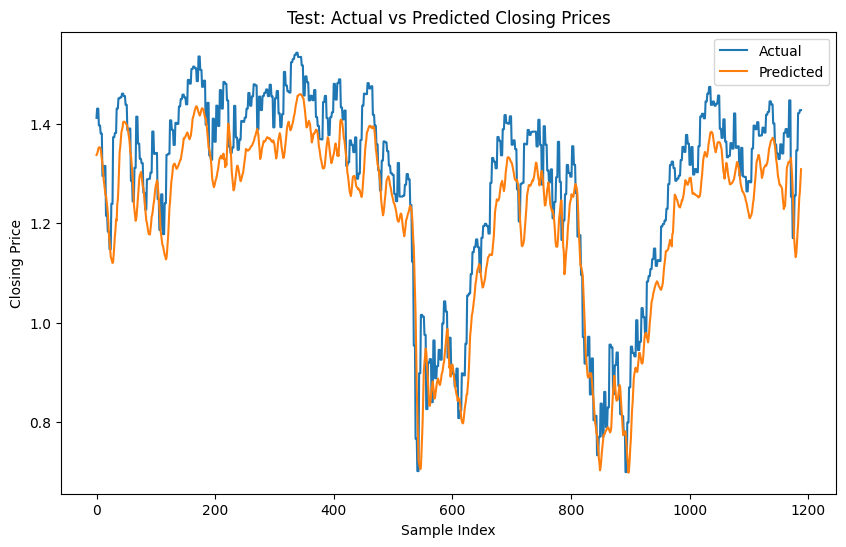

In [21]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for fin_data, lengths, input_ids, attention_mask, labels in test_loader:
        fin_data = fin_data.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        preds = model(fin_data, lengths, input_ids, attention_mask)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

mse_val = mean_squared_error(all_labels, all_preds)
rmse_val = np.sqrt(mse_val)
mape_val = np.mean(np.abs((all_labels - all_preds) / all_labels)) * 100
spearman_corr, _ = spearmanr(all_labels, all_preds)

print(f"Test MSE: {mse_val:.4f}")
print(f"Test RMSE: {rmse_val:.4f}")
print(f"Test MAPE: {mape_val:.2f}%")
print(f"Spearman Correlation: {spearman_corr:.4f}")

plt.figure(figsize=(10,6))
plt.plot(all_labels, label='Actual')
plt.plot(all_preds, label='Predicted')
plt.title('Test: Actual vs Predicted Closing Prices')
plt.xlabel('Sample Index')
plt.ylabel('Closing Price')
plt.legend()
plt.show()